
In this week's assignment, you'll build a model to predict bounding boxes around images.

    You will use transfer learning on any of the pre-trained models available in Keras.
    You'll be using the Caltech Birds - 2010 dataset.
    
dataset: http://www.vision.caltech.edu/visipedia/CUB-200.html

assignment: https://colab.research.google.com/drive/1ILAS7MJ4h29ZxX06SMbuZkdBQ2TQsPNb#scrollTo=Q6Pnix2iKXR5

solutions: https://github.com/sasidhar-programmer/Tensorflow_Advance_Techniques/blob/main/3-Advance_computer_vision/week%20-1/C3W1_Assignment.ipynb


In [13]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2


In [14]:
data_dir = os.environ['DATASETS_PATH']

BATCH_SIZE = 64

`draw_bounding_box_on_image`: Draws a single bounding box on an image.

`draw_bounding_boxes_on_image`: Draws multiple bounding boxes on an image.

`draw_bounding_boxes_on_image_array`: Draws multiple bounding boxes on an array of images.


In [15]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
    """
    Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    
    Args:
      image: a PIL.Image object.
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
    """
  
    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)


def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image.
    
    Args:
      image: a PIL.Image object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
                           
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)


def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image (numpy array).
    
    Args:
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: a list of strings for each bounding box.
    
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """

    draw_bounding_boxes_on_image(image, boxes, color, thickness)
  
    return image


    display_digits_with_boxes: This displays a row of "digit" images along with the model's predictions for each image.
    
    plot_metrics: This plots a given metric (like loss) as it changes over multiple epochs of training.


In [16]:
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):
# utility to display a row of digits with their predictions

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)
    
      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])
    
      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)
        
        
# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [17]:
def read_image_tfds(image, bbox):
    '''
        Resizes image to (224, 224)
        Normalizes image
        Translates and normalizes bounding boxes
    '''
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x , 
                 bbox[1] / factor_y, 
                 bbox[2] / factor_x , 
                 bbox[3] / factor_y]
    
    return image, bbox_list

In [18]:
def read_image_with_shape(image, bbox):
    '''This is very similar to read_image_tfds except it also keeps a copy of the
     original image (before pre-processing) and returns this as well.
     
        Makes a copy of the original image.
        Resizes image to (224, 224)
        Normalizes image
        Translates and normalizes bounding boxes
    '''
    original_image = image
    
    image, bbox_list = read_image_tfds(image, bbox)
    
    return original_image, image, bbox_list


In [19]:
def read_image_tfds_with_original_bbox(data):
    '''
    This function reads image from data
    It also denormalizes the bounding boxes
    (it undoes the bounding box normalization that is performed by the previous two helper functions.)
'''
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32) 
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x , 
                 bbox[0] * factor_y, 
                 bbox[3] * factor_x, 
                 bbox[2] * factor_y]
    return image, bbox_list

In [20]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):
    '''
    This function converts a `dataset` into numpy arrays of images and boxes.
    - This will be used when visualizing the images and their bounding boxes
    '''

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)
  
    if N > 0:
        take_dataset = take_dataset.take(N)
  
    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())
        
    return (np.array(ds_images), np.array(ds_bboxes))

In [21]:
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):
    '''
    This function converts a dataset into numpy arrays of
        original images
        resized and normalized images
        bounding boxes
    This will be used for plotting the original images with true and predicted bounding boxes.
    '''
    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)
  
    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []
        
    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)

tfds.core.DatasetInfo(
    name='caltech_birds2010',
    full_name='caltech_birds2010/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    data_path='/home/mo/Documents/ML-downloads/datasets/caltech_birds2010/0.1.1',
    download_size=659.14 MiB,
    dataset_size=659.64 MiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
        '

/home/mo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


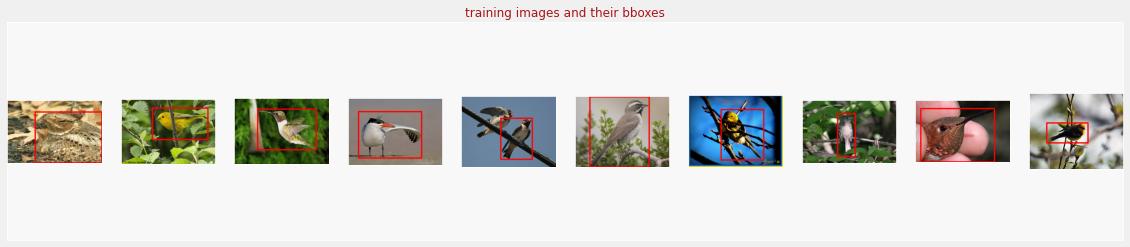

In [22]:
def get_visualization_training_dataset():      
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=data_dir, download=True)
    print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox, 
                                                 num_parallel_calls=16)
    return visualization_training_dataset


visualization_training_dataset = get_visualization_training_dataset()


(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")

/home/mo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


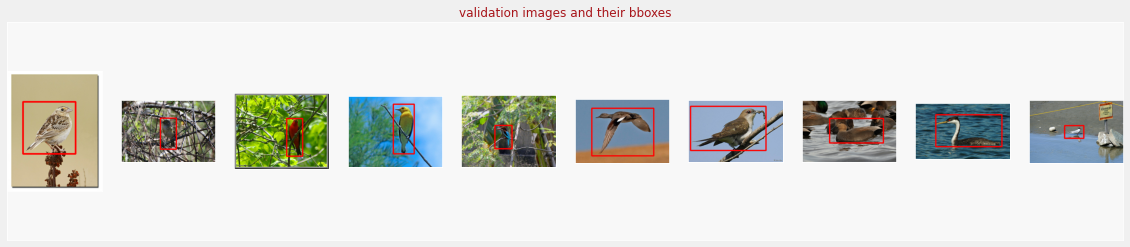

In [23]:
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", try_gcs=True, data_dir=data_dir)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset


visualization_validation_dataset = get_visualization_validation_dataset()

(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(  np.array(visualization_validation_images),
                            np.array([]),
                            np.array(visualization_validation_bboxes),
                            np.array([]),
                            "validation images and their bboxes"
                            )


In [24]:
# dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=data_dir)
# sample  = dataset.take(1).get_single_element()
# info
def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1) 
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

In [25]:
input_shape = (224,224,3)
def feature_extractor(inputs):
    ### YOUR CODE HERE ###
    
    # Create a mobilenet version 2 model object
    mobilenet_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape= input_shape, alpha=1.0, include_top=False, weights='imagenet', pooling=None)
    

    # pass the inputs into this modle object to get a feature extractor for these inputs
    feature_extractor = mobilenet_model(inputs)
    

    ### END CODE HERE ###
        
    # return the feature_extractor
    return feature_extractor

In [26]:
def dense_layers(features):
    ### YOUR CODE HERE ###

    # global average pooling 2d layer
    x = tf.keras.layers.GlobalAveragePooling2D()(features)
    
    # flatten layer
    x = tf.keras.layers.Flatten()(x)
    
    # 1024 Dense layer, with relu
    x = tf.keras.layers.Dense(units=1024, activation='relu')(x)
    
    # 512 Dense layer, with relu
    x = tf.keras.layers.Dense(units=512, activation='relu')(x)
    
    ### END CODE HERE ###
    
    return x

In [27]:
def bounding_box_regression(x):
    ### YOUR CODE HERE ###
    # 4 units in the output layer, corresponding to (xmin, ymin, xmax, ymax)
    # Dense layer named `bounding_box`
    bounding_box_regression_output = tf.keras.layers.Dense(units=4, name='bounding_box')(x)

    ### END CODE HERE ###
        

    return bounding_box_regression_output

In [28]:
def final_model(inputs):
    ### YOUR CODE HERE ###

    # features
    feature_cnn = feature_extractor(inputs)

    # dense layers
    last_dense_layer = dense_layers(features=feature_cnn) 

    # bounding box
    bounding_box_output = bounding_box_regression(last_dense_layer)
    
    # define the TensorFlow Keras model using the inputs and outputs to your model
    model = tf.keras.Model(inputs=inputs, outputs=bounding_box_output)

    ### END CODE HERE ###

    return model

In [29]:
def define_and_compile_model():
  
    ### YOUR CODE HERE ###

    # define the input layer
    inputs = tf.keras.layers.Input(input_shape)
    
    # create the model
    model = final_model(inputs)
    
    # compile your model
    sgd = tf.keras.optimizers.SGD(
    learning_rate=0.01, nesterov=True)

    model.compile(optimizer=sgd, loss='mse')

    ### END CODE HERE ###
    

    return model

In [30]:
# define your model
model = define_and_compile_model()
# print model layers
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
bounding_box (Dense)         (None, 4)                 2052  

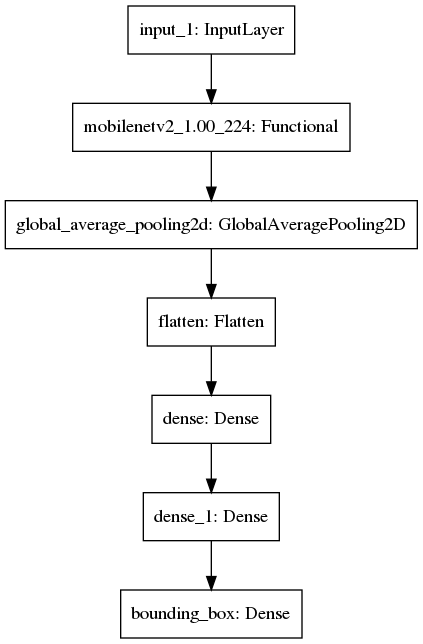

In [31]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [32]:
# You'll train 50 epochs
EPOCHS = 50

### START CODE HERE ###

# Choose a batch size
BATCH_SIZE = 64

# Get the length of the training set
length_of_training_dataset = len(visualization_training_dataset)

# Get the length of the validation set
length_of_validation_dataset = len(visualization_validation_dataset)

# Get the steps per epoch (may be a few lines of code)
# If the number of training examples is not evenly divisible by the batch size,
#  there will be one last batch that is not the full batch size.
# Try to calculate the number steps it would take to train all the full batches plus one more batch containing
#  the remaining training examples. There are a couples ways you can calculate this
steps_per_epoch = length_of_training_dataset // BATCH_SIZE

# get the validation steps (per epoch) (may be a few lines of code)
validation_steps = length_of_validation_dataset//BATCH_SIZE
if length_of_validation_dataset % BATCH_SIZE > 0:
    validation_steps += 1
    
### END CODE HERE

In [33]:
### YOUR CODE HERE ####

# Fit the model, setting the parameters noted in the instructions above.
history = model.fit(training_dataset , steps_per_epoch= steps_per_epoch, validation_data=validation_dataset, validation_steps = validation_steps, epochs = EPOCHS)
### END CODE HERE ###


Epoch 1/50
46/46 [==============================] - 26s 388ms/step - loss: 0.1292 - val_loss: 0.0822
Epoch 2/50
46/46 [==============================] - 17s 371ms/step - loss: 0.0641 - val_loss: 0.0723
Epoch 3/50
46/46 [==============================] - 17s 369ms/step - loss: 0.0486 - val_loss: 0.0678
Epoch 4/50
46/46 [==============================] - 16s 358ms/step - loss: 0.0390 - val_loss: 0.0720
Epoch 5/50
46/46 [==============================] - 17s 361ms/step - loss: 0.0331 - val_loss: 0.0690
Epoch 6/50
46/46 [==============================] - 17s 371ms/step - loss: 0.0291 - val_loss: 0.0661
Epoch 7/50
46/46 [==============================] - 17s 361ms/step - loss: 0.0263 - val_loss: 0.0681
Epoch 8/50
46/46 [==============================] - 17s 365ms/step - loss: 0.0236 - val_loss: 0.0680
Epoch 9/50
46/46 [==============================] - 17s 370ms/step - loss: 0.0213 - val_loss: 0.0666
Epoch 10/50
46/46 [==============================] - 17s 365ms/step - loss: 0.0205 - val_lo

In [34]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

48/48 [==============================] - 3s 60ms/step - loss: 0.0340
Loss:  0.03403129428625107


In [35]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

In [36]:
#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.7

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))


/home/mo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Number of predictions where iou > threshold(0.7): 25
Number of predictions where iou < threshold(0.7): 475


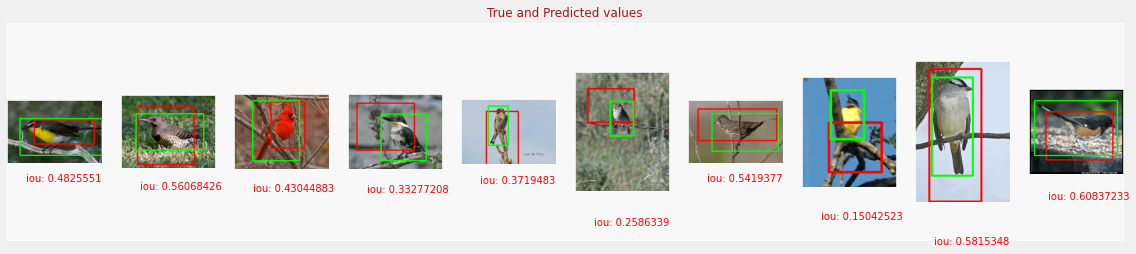

In [37]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)